In [1]:
import pandas as pd
import matplotlib
import random as rd
import datetime
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from prophet import Prophet
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('google-data.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [3]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
data['date'] = pd.to_datetime(data['Date']).dt.strftime("%d/%m/%y")
data.drop('Date', axis =1, inplace = True)

In [5]:
# Friday and Sunday dates were added

df = pd.DataFrame()
df['date'] = pd.date_range(start = '2013-01-02', end = '2017-12-29')
df['date'] = df['date'].dt.strftime("%d/%m/%y")
df = df.merge(data, how = 'left', on = 'date')
df

,date,Open,High,Low,Close,Adj Close,Volume
0,02/01/13,357.385559,361.151062,355.959839,359.288177,359.288177,5115500.0
1,03/01/13,360.122742,363.600128,358.031342,359.496826,359.496826,4666500.0
2,04/01/13,362.313507,368.339294,361.488861,366.600616,366.600616,5562800.0
3,05/01/13,NaN,NaN,NaN,NaN,NaN,NaN
4,06/01/13,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1818,25/12/17,NaN,NaN,NaN,NaN,NaN,NaN
1819,26/12/17,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600.0
1820,27/12/17,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900.0
1821,28/12/17,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100.0


In [6]:
df.isnull().sum()

date           0
Open         564
High         564
Low          564
Close        564
Adj Close    564
Volume       564
dtype: int64

In [7]:
df.info()
df['date'] = pd.to_datetime(df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823 entries, 0 to 1822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1823 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.8+ KB


C:\Users\DELL\AppData\Local\Temp\ipykernel_17992\1953367644.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [8]:
# missing values were filled with the cubic method

num_cols = df.select_dtypes(include=['int64','float64'])
for i in num_cols:
    df[i] = df[i].interpolate(method = 'cubic')

In [9]:
df

,date,Open,High,Low,Close,Adj Close,Volume
0,2013-02-01,357.385559,361.151062,355.959839,359.288177,359.288177,5.115500e+06
1,2013-03-01,360.122742,363.600128,358.031342,359.496826,359.496826,4.666500e+06
2,2013-04-01,362.313507,368.339294,361.488861,366.600616,366.600616,5.562800e+06
3,2013-05-01,363.672264,370.177059,364.091857,369.244832,369.244832,5.329146e+06
4,2013-06-01,364.524566,369.314551,364.813292,367.666599,367.666599,4.257799e+06
...,...,...,...,...,...,...,...
1818,2017-12-25,1057.739346,1060.423291,1052.050019,1060.584585,1060.584585,3.650801e+05
1819,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,7.606000e+05
1820,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1.271900e+06
1821,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,8.371000e+05


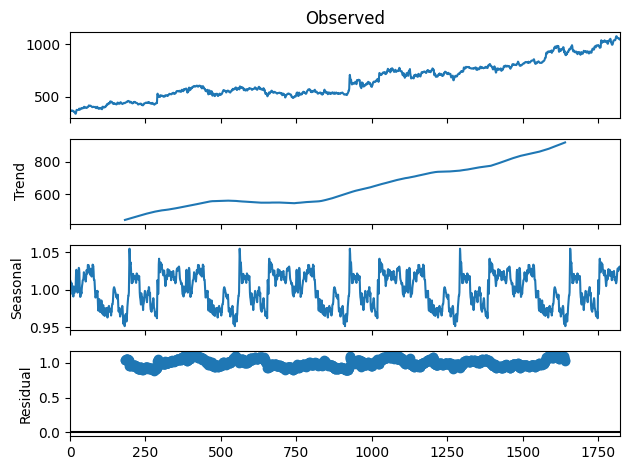

In [10]:
a = sm.tsa.seasonal_decompose(df.Close.values, period = 365, model = 'additive')
m = sm.tsa.seasonal_decompose(df.Close.values, period = 365, model = 'multiplicative')
plot = m.plot()

In [13]:
def st_check(timeseries):
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    print(dfoutput)
st_check(data.Close)

Test Statistic                   -0.250610
p-value                           0.932214
Lags Used                         0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


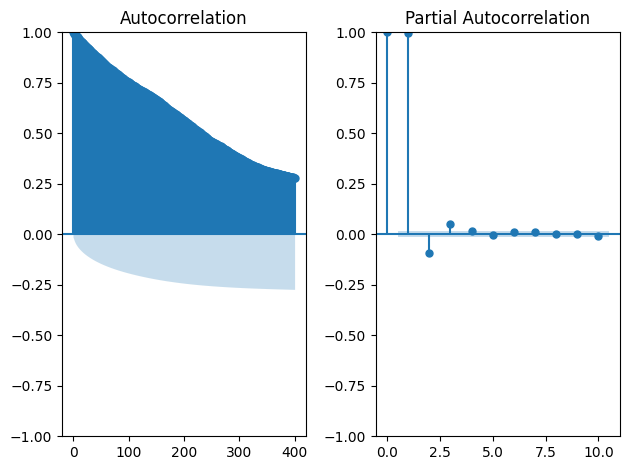

In [28]:
l = (1,2)

a = plt.subplot2grid((1,2),(0,0))
p = plt.subplot2grid((1,2),(0,1))
smt.graphics.plot_acf(df.Close, lags = 400, ax = a, alpha = 0.5)
smt.graphics.plot_pacf(df.Close, lags = 10, ax = p, alpha = 0.5)
plt.tight_layout()

In [15]:
model_df = df.loc[:,['date', 'Close']].rename(columns = {'date':'ds', 'Close':'y'})
model_df

,ds,y
0,2013-02-01,359.288177
1,2013-03-01,359.496826
2,2013-04-01,366.600616
3,2013-05-01,369.244832
4,2013-06-01,367.666599
...,...,...
1818,2017-12-25,1060.584585
1819,2017-12-26,1056.739990
1820,2017-12-27,1049.369995
1821,2017-12-28,1048.140015


In [16]:

model = Prophet(yearly_seasonality =True, interval_width = 0.95)
model.fit(model_df)

15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
ft = model.make_future_dataframe(periods = 100)
pred = model.predict(ft)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1918,2018-04-04,1082.080570,991.291964,1175.375093
1919,2018-04-05,1083.438098,987.354211,1166.909207
1920,2018-04-06,1081.550226,989.894200,1179.474895
1921,2018-04-07,1081.275608,984.244351,1179.193796
1922,2018-04-08,1081.361089,987.082704,1177.091056


Text(0.5, 1.0, 'Google Stock Prices')

<Figure size 1600x800 with 0 Axes>

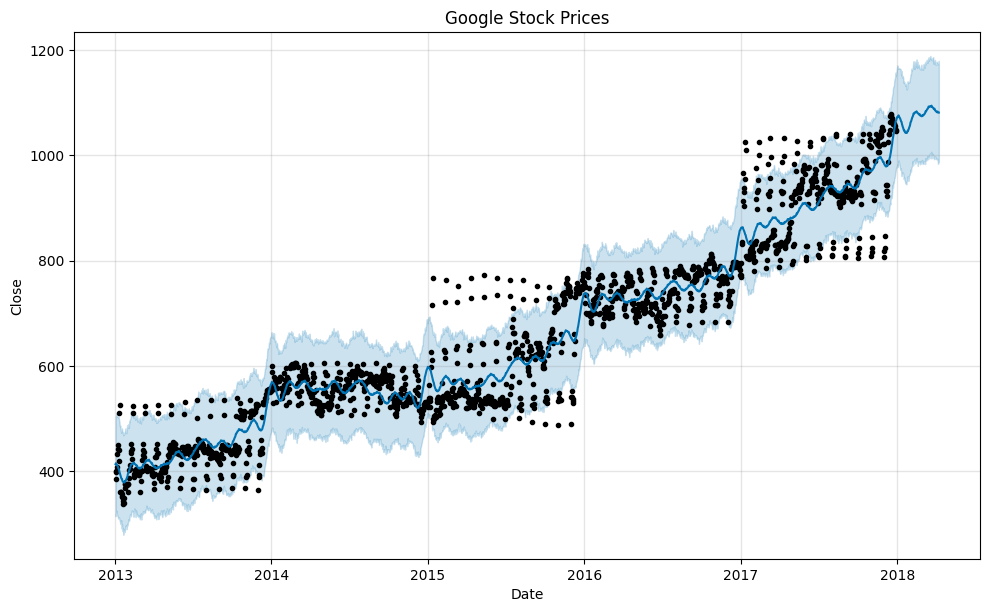

In [19]:
plt.figure(figsize=(16,8))
model.plot(pred, xlabel = 'Date', ylabel = 'Close')
plt.title('Google Stock Prices')

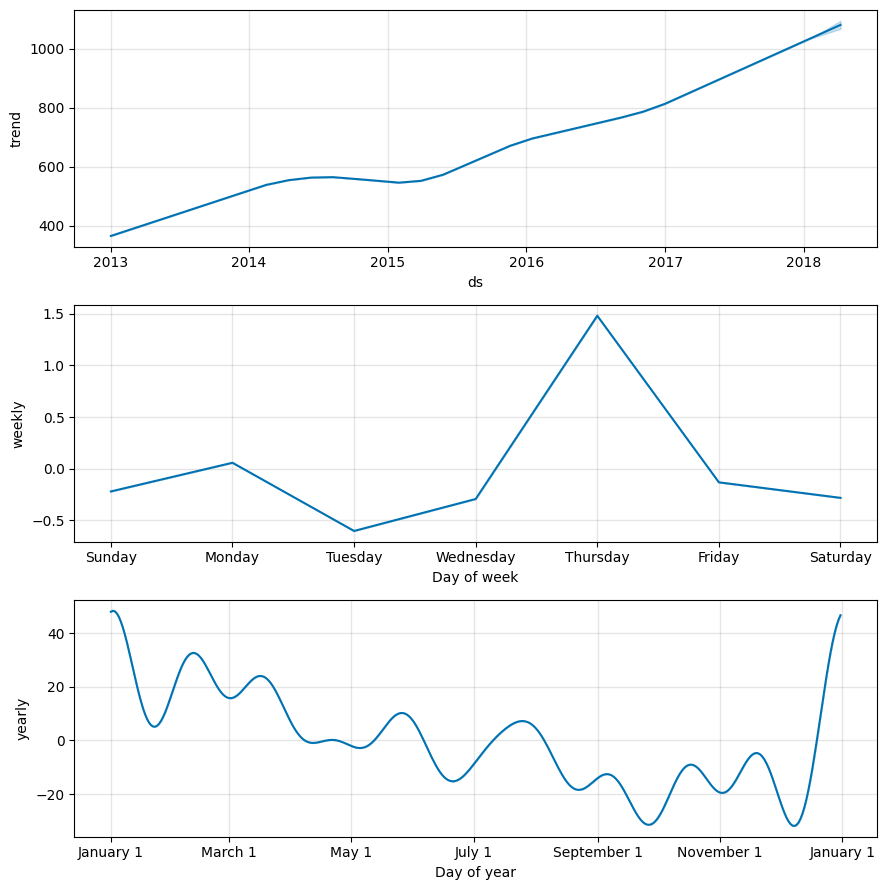

In [20]:
fig = model.plot_components(pred)